# RoseTTAFold
**Limitations**
- This notebook disables a few aspects (templates, pytosetta) of the full rosettafold pipeline.
- For best resuls use the [full pipeline](https://github.com/RosettaCommons/RoseTTAFold) or [Robetta webserver](https://robetta.bakerlab.org/)!
- For a typical Google-Colab session, with a `16G-GPU`, the max total length is **700 residues**. Sometimes a `12G-GPU` is assigned, in which case the max length is lower.
- For version of RoseTTAFold that runs with pyRosetta [see here](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/beta/RoseTTAFold.ipynb).

For other related notebooks see [ColabFold](https://github.com/sokrypton/ColabFold)

In [1]:
#@title ##Install and import libraries
#@markdown This step can take up to ~2 mins

import os
import sys
from IPython.utils import io
from google.colab import files

import torch
torch_v = torch.__version__


if not os.path.isdir("RoseTTAFold"):
  with io.capture_output() as captured:
    # extra functionality
    %shell wget -qnc https://raw.githubusercontent.com/sokrypton/ColabFold/main/beta/colabfold.py

    # download model
    %shell git clone https://github.com/RosettaCommons/RoseTTAFold.git
    %shell wget -qnc https://raw.githubusercontent.com/sokrypton/ColabFold/main/beta/RoseTTAFold__network__Refine_module.patch
    %shell patch -u RoseTTAFold/network/Refine_module.py -i RoseTTAFold__network__Refine_module.patch

    # download model params
    %shell wget -qnc https://files.ipd.uw.edu/pub/RoseTTAFold/weights.tar.gz
    %shell tar -xf weights.tar.gz
    %shell rm weights.tar.gz

    # download scwrl4 (for adding sidechains)
    # http://dunbrack.fccc.edu/SCWRL3.php
    # Thanks Roland Dunbrack!
    %shell wget -qnc https://files.ipd.uw.edu/krypton/TrRosetta/scwrl4.zip
    %shell unzip -qqo scwrl4.zip

    # install libraries
    %shell pip install -q dgl-cu113 -f https://data.dgl.ai/wheels/repo.html
    %shell pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-{torch_v}.html
    %shell pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-{torch_v}.html
    %shell pip install -q torch-geometric
    %shell pip install -q py3Dmol

with io.capture_output() as captured:
  sys.path.append('/content/RoseTTAFold/network')
  import predict_e2e
  from parsers import parse_a3m

import colabfold as cf
import py3Dmol
import subprocess
import numpy as np
import matplotlib.pyplot as plt

def get_bfactor(pdb_filename):
  bfac = []
  for line in open(pdb_filename,"r"):
    if line[:4] == "ATOM":
      bfac.append(float(line[60:66]))
  return np.array(bfac)

def set_bfactor(pdb_filename, bfac):
  I = open(pdb_filename,"r").readlines()
  O = open(pdb_filename,"w")
  for line in I:
    if line[0:6] == "ATOM  ":
      seq_id = int(line[22:26].strip()) - 1
      O.write(f"{line[:60]}{bfac[seq_id]:6.2f}{line[66:]}")
  O.close()

def do_scwrl(inputs, outputs, exe="./scwrl4/Scwrl4"):
  subprocess.run([exe,"-i",inputs,"-o",outputs,"-h"],
                  stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
  bfact = get_bfactor(inputs)
  set_bfactor(outputs, bfact)
  return bfact

In [2]:
#@markdown ##Input Sequence
sequence = "MSTKKKPLTQEQLEDARRLKAIYEKKKNELGLSQESVADKMGMGQSGVGALFNGINALNAYNAALLTKILKVSVEEFSPSIAREIYEMYEAVSMQPSLRSEYEYPVFSHVQAGMFSPELRTFTKGDAERWVSTTKKASDSAFWLEVEGNSMTAPTGSKPSFPDGMLILVDPEQAVEPGDFCIARLGGDEFTFKKLIRDSGQVFLQPLNPQYPMIPCNESCSVVGKVIASQWPEETFG" #@param {type:"string"}
sequence = sequence.translate(str.maketrans('', '', ' \n\t')).upper()

jobname = "test" #@param {type:"string"}
jobname = jobname+"_"+cf.get_hash(sequence)[:5]

  0%|          | 0/150 [elapsed: 00:00 remaining: ?]


5239 Sequences Found in Total (after filtering)



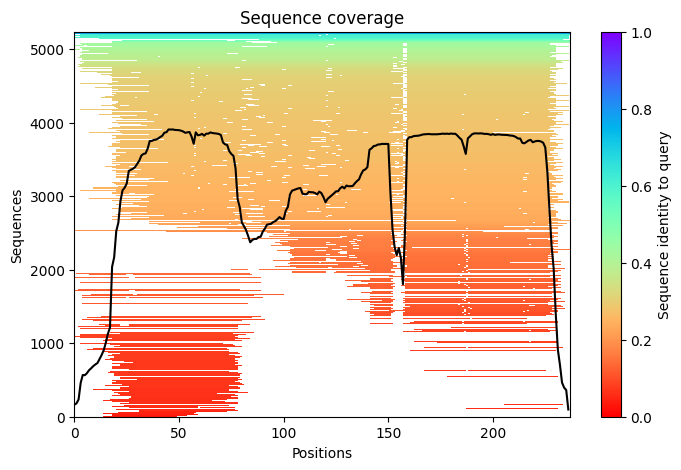

In [3]:
#@title Search against genetic databases
#@markdown ---
msa_method = "mmseqs2" #@param ["mmseqs2","single_sequence","custom_a3m"]
#@markdown - `mmseqs2` - FAST method from [ColabFold](https://github.com/sokrypton/ColabFold)
#@markdown - `single_sequence` - use single sequence input (not recommended, unless a *denovo* design and you dont expect to find any homologous sequences)
#@markdown - `custom_a3m` Upload custom MSA (a3m format)

# tmp directory
prefix = cf.get_hash(sequence)
os.makedirs('tmp', exist_ok=True)
prefix = os.path.join('tmp',prefix)

os.makedirs(jobname, exist_ok=True)


if msa_method == "mmseqs2":
  a3m_lines = cf.run_mmseqs2(sequence, prefix, filter=True)
  with open(f"{jobname}/msa.a3m","w") as a3m:
    a3m.write(a3m_lines)

elif msa_method == "single_sequence":
  with open(f"{jobname}/msa.a3m","w") as a3m:
    a3m.write(f">{jobname}\n{sequence}\n")

elif msa_method == "custom_a3m":
  print("upload custom a3m")
  msa_dict = files.upload()
  lines = msa_dict[list(msa_dict.keys())[0]].decode().splitlines()
  a3m_lines = []
  for line in lines:
    line = line.replace("\x00","")
    if len(line) > 0 and not line.startswith('#'):
      a3m_lines.append(line)

  with open(f"{jobname}/msa.a3m","w") as a3m:
    a3m.write("\n".join(a3m_lines))

msa_all = parse_a3m(f"{jobname}/msa.a3m")
msa_arr = np.unique(msa_all,axis=0)
total_msa_size = len(msa_arr)
if msa_method == "mmseqs2":
  print(f'\n{total_msa_size} Sequences Found in Total (after filtering)\n')
else:
  print(f'\n{total_msa_size} Sequences Found in Total\n')

if total_msa_size > 1:
  plt.figure(figsize=(8,5),dpi=100)
  plt.title("Sequence coverage")
  seqid = (msa_all[0] == msa_arr).mean(-1)
  seqid_sort = seqid.argsort()
  non_gaps = (msa_arr != 20).astype(float)
  non_gaps[non_gaps == 0] = np.nan
  plt.imshow(non_gaps[seqid_sort]*seqid[seqid_sort,None],
            interpolation='nearest', aspect='auto',
            cmap="rainbow_r", vmin=0, vmax=1, origin='lower',
            extent=(0, msa_arr.shape[1], 0, msa_arr.shape[0]))
  plt.plot((msa_arr != 20).sum(0), color='black')
  plt.xlim(0,msa_arr.shape[1])
  plt.ylim(0,msa_arr.shape[0])
  plt.colorbar(label="Sequence identity to query",)
  plt.xlabel("Positions")
  plt.ylabel("Sequences")
  plt.savefig(f"{jobname}/msa_coverage.png", bbox_inches = 'tight')
  plt.show()

/usr/local/lib/python3.10/dist-packages/dgl/backend/pytorch/tensor.py:352: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), "Cannot convert view " \


SE(3) iteration 0 [0.4456]
SE(3) iteration 1 [0.541]
SE(3) iteration 2 [0.5825]
SE(3) iteration 3 [0.6074]
SE(3) iteration 4 [0.627]
SE(3) iteration 5 [0.6475]
SE(3) iteration 6 [0.6533]
SE(3) iteration 7 [0.6577]
SE(3) iteration 8 [0.66]
SE(3) iteration 9 [0.6597]
SE(3) iteration 10 [0.659]
SE(3) iteration 11 [0.659]
SE(3) iteration 12 [0.6577]
SE(3) iteration 13 [0.658]
SE(3) iteration 14 [0.658]
SE(3) iteration 15 [0.658]
SE(3) iteration 16 [0.658]
SE(3) iteration 17 [0.6587]
SE(3) iteration 18 [0.659]
SE(3) iteration 19 [0.659]
SE(3) iteration 20 [0.658]
SE(3) iteration 21 [0.657]
SE(3) iteration 22 [0.657]
SE(3) iteration 23 [0.6567]
SE(3) iteration 24 [0.6567]
SE(3) iteration 25 [0.6567]
SE(3) iteration 26 [0.657]
SE(3) iteration 27 [0.6577]
SE(3) iteration 28 [0.6577]
SE(3) iteration 29 [0.6577]
SE(3) iteration 0 [0.4302]
SE(3) iteration 1 [0.5605]
SE(3) iteration 2 [0.614]
SE(3) iteration 3 [0.6304]
SE(3) iteration 4 [0.627]
SE(3) iteration 5 [0.6284]
SE(3) iteration 6 [0.6133]

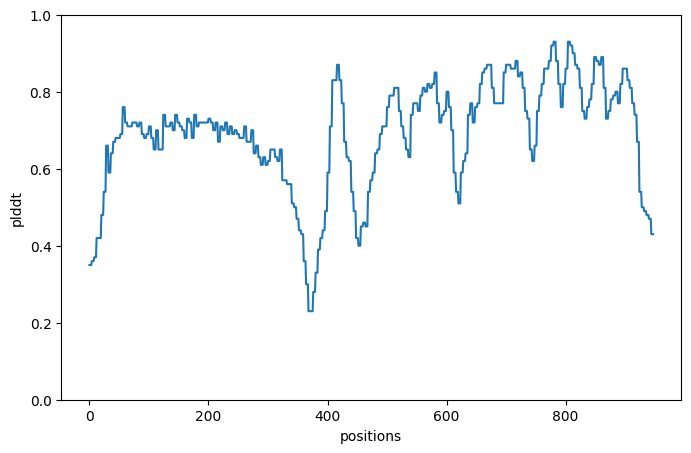

In [4]:
#@title ## Run RoseTTAFold for mainchain and Scrwl4 for sidechain prediction

# load model
if "rosettafold" not in dir():
  rosettafold = predict_e2e.Predictor(model_dir="weights")

# make prediction using model
rosettafold.predict(f"{jobname}/msa.a3m",f"{jobname}/pred")

# pack sidechains using Scwrl4
plddt = do_scwrl(f"{jobname}/pred.pdb",f"{jobname}/pred.scwrl.pdb")

print(f"Predicted LDDT: {plddt.mean()}")

plt.figure(figsize=(8,5),dpi=100)
plt.plot(plddt)
plt.xlabel("positions")
plt.ylabel("plddt")
plt.ylim(0,1)
plt.savefig(f"{jobname}/plddt.png", bbox_inches = 'tight')
plt.show()


In [ ]:
#@title Display 3D structure {run: "auto"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = True #@param {type:"boolean"}
show_mainchains = True #@param {type:"boolean"}
cf.show_pdb(f"{jobname}/pred.scwrl.pdb", show_sidechains, show_mainchains, color, chains=1, vmin=0.5, vmax=0.9).show()

if color == "lDDT": cf.plot_plddt_legend().show()

In [ ]:
#@title Download prediction

#@markdown Once this cell has been executed, a zip-archive with
#@markdown the obtained prediction will be automatically downloaded
#@markdown to your computer.

# add settings file
settings_path = f"{jobname}/settings.txt"
with open(settings_path, "w") as text_file:
  text_file.write(f"method=RoseTTAFold\n")
  text_file.write(f"sequence={sequence}\n")
  text_file.write(f"msa_method={msa_method}\n")
  text_file.write(f"use_templates=False\n")

# --- Download the predictions ---
!zip -q -r {jobname}.zip {jobname}
files.download(f'{jobname}.zip')